In [414]:
from qiskit import Aer, QuantumCircuit, QuantumRegister, ClassicalRegister, execute
from qiskit.aqua.algorithms import AmplitudeEstimation
from qiskit.circuit.library import QFT, GroverOperator

from qiskit.aqua.algorithms.amplitude_estimators.q_factory import QFactory

import math
import numpy as np
import matplotlib.pyplot as plt

In [451]:
evaluation_qubits = 6

probability = 0.3
theta = 2 * np.arcsin(np.sqrt(probability))

evaluation_registry = QuantumRegister(evaluation_qubits, 'evaluation')
a_registry = QuantumRegister(1, 'q')

## First with the Qiskit function

In [281]:
a_factory =  QuantumCircuit(a_registry)
a_factory.ry(theta, a_registry[0])
backend = Aer.get_backend('statevector_simulator')
job = execute(a_factory, backend, shots=1024)
counts = job.result().get_counts()
print(counts)

{'0': 0.7, '1': 0.3}


In [290]:
ae = AmplitudeEstimation(evaluation_qubits, a_factory)
result = ae.run(quantum_instance=Aer.get_backend('qasm_simulator'))

In [291]:
result

{'a_estimation': 0.1464466, 'confidence_interval': [0.29585582557327694, 0.3083388005912109], 'estimation': 0.1464466, 'num_oracle_queries': 7168, 'ml_value': 0.3020762137271272, 'mapped_a_samples': [0.0, 0.1464466, 0.5, 0.8535534, 1.0], 'probabilities': [0.0673828125, 0.4541015625, 0.3935546875, 0.0654296875, 0.01953125], 'shots': 1024, 'mle': 0.3020762137271272, 'circuit_result': {'000': 69, '001': 20, '010': 206, '011': 197, '100': 236, '101': 36, '110': 31, '111': 229}, 'a_samples': [(0.0, 0.0673828125), (0.1464466, 0.4541015625), (0.5, 0.3935546875), (0.8535534, 0.0654296875), (1.0, 0.01953125)], 'y_measurements': [(0, 0.0673828125), (1, 0.23046875), (2, 0.201171875), (3, 0.0302734375), (4, 0.01953125), (5, 0.03515625), (6, 0.1923828125), (7, 0.2236328125)], 'mapped_values': [0.0, 0.1464466, 0.5, 0.8535534, 1.0], 'max_probability': 0.4541015625}

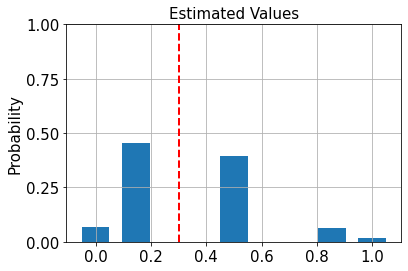

In [292]:
# plot estimated values
plt.bar(result['mapped_a_samples'], result['probabilities'], width=0.5/len(result['probabilities']))
plt.plot([probability, probability], [0,1], 'r--', linewidth=2)
plt.xticks(size=15)
plt.yticks([0, 0.25, 0.5, 0.75, 1], size=15)
plt.title('Estimated Values', size=15)
plt.ylabel('Probability', size=15)
plt.ylim((0,1))
plt.grid()
plt.show()

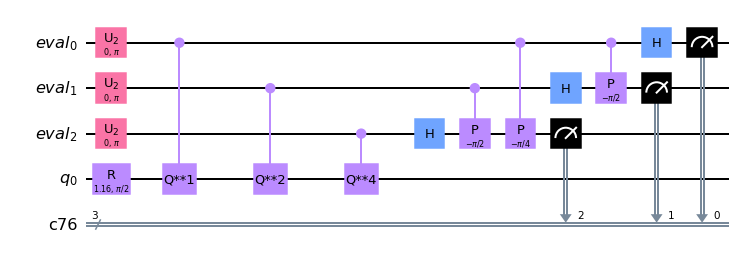

In [481]:
ae._circuit.decompose().draw('mpl')

Q Operator

$$ \mathcal{Q} = \mathcal{A} \mathcal{S}_0 \mathcal{A}^\dagger \mathcal{S}_f, $$

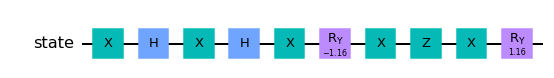

In [326]:
ae.grover_operator.draw('mpl')

## Design our own AE

In [471]:
def qft_dagger(qc, n):
    """n-qubit QFTdagger the first n qubits in circ"""
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-math.pi/float(2**(j-m)), m, j)
        qc.h(j)

    
def spsi(n):    
    s_psi0 = QuantumCircuit(n + 1)
    s_psi0.z(n)
    return s_psi0
    
def s0(n):
    s0 = QuantumCircuit(n)
    s0.x(n - 1)
    s0.h(n - 1)
    s0.mcx(list(range(n - 1)), n - 1)
    s0.h(n - 1)
    s0.x(n - 1)
    return s0

def a_operator():
    qc = QuantumCircuit(1)
    qc.ry(theta, 0, label='a')
    return qc

def q_operator2(objective_qubits, num_state_qubits):
    num_state_qubits = self.state_preparation.num_qubits - self.state_preparation.num_ancillas

    oracle = QuantumCircuit(num_state_qubits)
    oracle.x(self.objective_qubits)
    oracle.h(self.objective_qubits[-1])
    if len(self.objective_qubits) == 1:
        oracle.x(self.objective_qubits[0])
    else:
        oracle.mcx(self.objective_qubits[:-1], self.objective_qubits[-1])
    oracle.h(self.objective_qubits[-1])
    oracle.x(self.objective_qubits)

    # construct the grover operator
    return GroverOperator(oracle, self.state_preparation)

def q_operator(num_state_qubits):
    oracle = QuantumCircuit(num_state_qubits)
    oracle.x(range(num_state_qubits))
    oracle.h(range(num_state_qubits)[-1])

    oracle.mcx(range(num_state_qubits)[:-1], range(num_state_qubits)[-1])
    oracle.h(range(num_state_qubits)[-1])
    oracle.x(range(num_state_qubits))

    # construct the grover operator
    return GroverOperator(oracle)


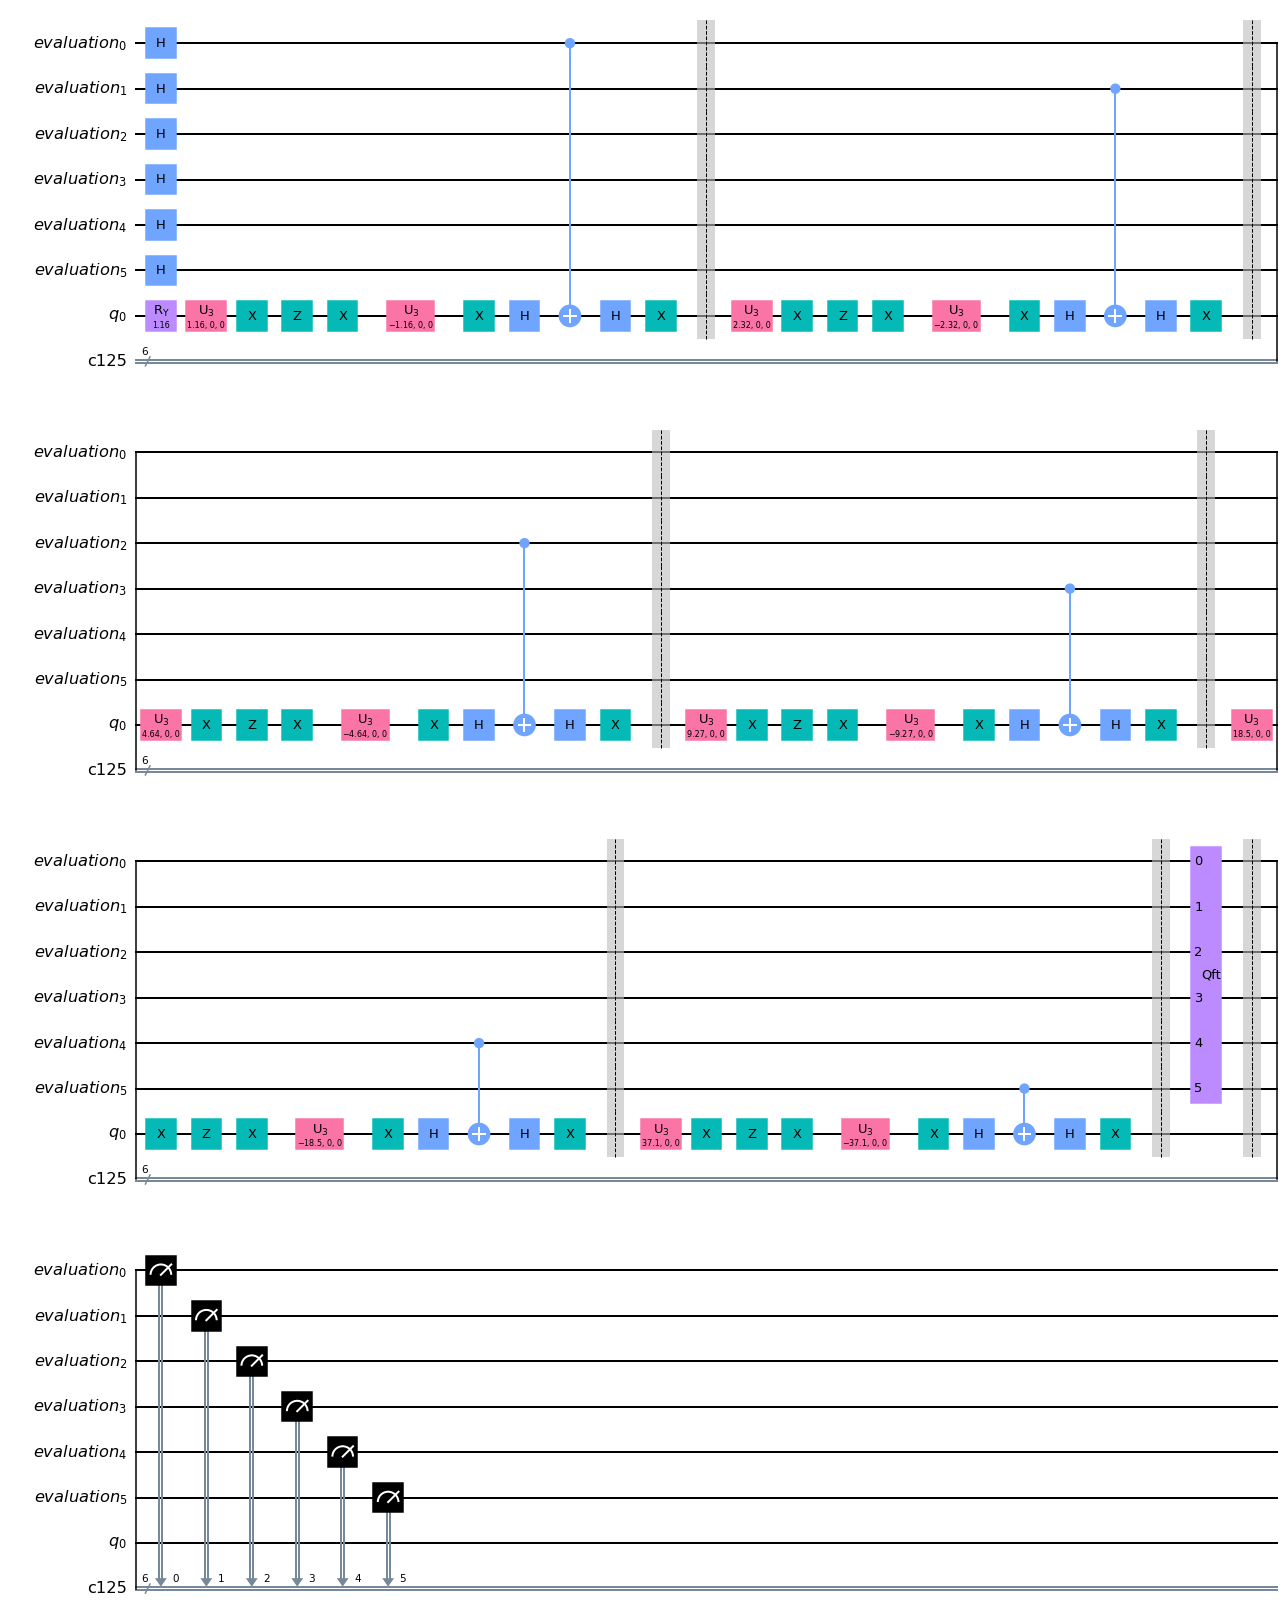

In [477]:
cr = ClassicalRegister(evaluation_qubits)
qc = QuantumCircuit(evaluation_registry, a_registry, cr)

#qc.append(a_operator(), a_registry)

# A
qc.ry(theta, a_registry)

qc.h(range(evaluation_qubits))

#Do the controlled-U operations:
# 𝑄=𝐴𝑆0𝐴−1𝑆𝜓0
repetitions = 1
for counting_qubit in range(evaluation_qubits):
    
    # A
    qc.u3(theta*repetitions,0,0, evaluation_qubits); 
    
    # S0
    qc.x(evaluation_qubits)
    qc.z(evaluation_qubits) 
    qc.x(evaluation_qubits)
    
    # A-1
    qc.u3(-theta*repetitions,0,0, evaluation_qubits); 
    
    # Spsi0
    qc.x(evaluation_qubits)
    qc.h(evaluation_qubits)
    qc.cx(counting_qubit, evaluation_qubits)
    qc.h(evaluation_qubits)
    qc.x(evaluation_qubits)
    
    qc.barrier()
    repetitions *= 2


#qft_dagger(qc, evaluation_qubits)
qc.append(QFT(evaluation_qubits, inverse=True, do_swaps=False), range(evaluation_qubits))
qc.barrier()
qc.measure(range(evaluation_qubits), cr)
qc.draw('mpl')

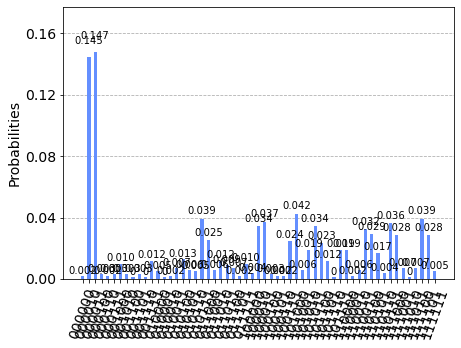

In [478]:
from qiskit.visualization import plot_histogram

backend = Aer.get_backend('qasm_simulator')
results = execute(qc, backend=backend, shots=1024).result()
counts = results.get_counts()

plot_histogram(counts)

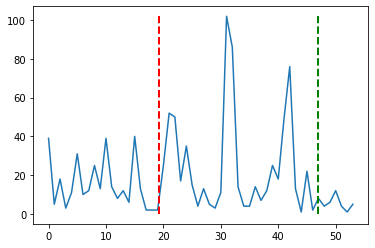

In [465]:
plt.plot(counts.values())
# Real (Red)
plt.plot([probability * 2**evaluation_qubits, probability * 2**evaluation_qubits], [0,max(counts.values())], 'r--', linewidth=2)
# Calculated (Green)
plt.plot([int(max(counts, key=counts.get),2), int(max(counts, key=counts.get),2)], [0,max(counts.values())], 'g--', linewidth=2)
plt.show()

In [461]:
print("Most probably state: ", max(counts, key=counts.get), "-- ", int(max(counts, key=counts.get),2))
estimated_probability = int(max(counts, key=counts.get),2) / 2**evaluation_qubits
print("Estimated Probability: theta = state / 2^n :", estimated_probability)
print("Real Probability: ", probability)
print("Error: ", estimated_probability - probability)

Most probably state:  000110 --  6
Estimated Probability: theta = state / 2^n : 0.09375
Real Probability:  0.3
Error:  -0.20625


In [462]:
for i in counts:
    estimated_probability = int(i,2) / 2**evaluation_qubits
    print(i, " : ", counts[i], " - ", estimated_probability)

000001  :  4  -  0.015625
010000  :  1  -  0.25
010001  :  14  -  0.265625
010010  :  1  -  0.28125
010011  :  5  -  0.296875
010100  :  1  -  0.3125
010111  :  1  -  0.359375
011001  :  2  -  0.390625
011010  :  1  -  0.40625
011100  :  7  -  0.4375
011101  :  5  -  0.453125
011110  :  9  -  0.46875
000010  :  1  -  0.03125
100000  :  3  -  0.5
100001  :  10  -  0.515625
100010  :  2  -  0.53125
100011  :  12  -  0.546875
100100  :  1  -  0.5625
100101  :  7  -  0.578125
100110  :  12  -  0.59375
100111  :  1  -  0.609375
101000  :  9  -  0.625
101001  :  42  -  0.640625
101010  :  1  -  0.65625
101011  :  26  -  0.671875
101100  :  48  -  0.6875
101101  :  10  -  0.703125
101110  :  58  -  0.71875
101111  :  15  -  0.734375
110000  :  10  -  0.75
110001  :  52  -  0.765625
110010  :  9  -  0.78125
110011  :  50  -  0.796875
110100  :  14  -  0.8125
110110  :  25  -  0.84375
110111  :  8  -  0.859375
111001  :  10  -  0.890625
111010  :  14  -  0.90625
111100  :  9  -  0.9375
111101  